Our baseline model is an OLS model with feature selction being done through a filter method (univariate).Our results indicate that minimum temperature, precipitation, and number of intersections are the most important features to predict air quality.

The code chunks below consists of all other models we developed.

In [34]:
#Import basic python packages for data analysis and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.lines as mlines
import pylab as plot
import matplotlib
import random
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
import time

### Import Scipy stats packages
from scipy.stats import pearsonr
from scipy.stats import boxcox

# import sklearn packages
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet
import pickle

import re
import os

import torch

import warnings
warnings.filterwarnings("ignore")

sns.set(style = 'whitegrid')
sns.set_palette('bright')
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## (A) Dataset prep

In [35]:
# merge all datasets to create master_df

root = os.path.dirname(os.path.dirname(os.getcwd()))

df_aq = pd.read_csv(root + "/data/cleaned/air_quality_NO2.csv", index_col=0)[['value','latitude', 'longitude']]
df_met = pd.read_csv(root + "/data/cleaned/nO2_met.csv", index_col=0)
df_fac = pd.read_csv(root + "/data/cleaned/no2_fac_data.csv", index_col=0)
# df_fac.drop(df_fac.columns[df_fac.columns.str.contains('_emsdist')], axis=1, inplace=True)
df_traffic = pd.read_csv(root + "/data/cleaned/intersection_final.csv", index_col=0)

df_m1 = df_aq.merge(df_met, on = ['latitude', 'longitude'], how = 'inner')
df_m2 = df_m1.merge(df_fac, on = ['latitude', 'longitude'], how = 'inner')
df_merged = df_m2.merge(df_traffic, on = ['latitude', 'longitude'], how = 'inner')
df_merged.drop(columns = ['latitude', 'longitude'], inplace=True)

X = df_merged.drop("value",1) 
y = df_merged["value"]

## (B) Modeling - Using Cross Validation and Randomized/Grid Search

In [ ]:
#NB -- Code to get list of params for an estimator:
#regressor.get_params().keys()

In [9]:
# function to scale and transform input data
def get_data(X, y):
    X = X.values
    y = y.values
    # scaling the data
    feature_scaler = StandardScaler()
    X = feature_scaler.fit_transform(X)
    return X, y

# acquiring transformed data
X_arr, y_arr = get_data(X, y)
cols = np.array(X.columns)

# master list for all model scores
model_scores = {}

### (1) Random forest

In [ ]:
def rf_tuning(X_arr, y_arr, grid_param):
    print("Tuning model")
    # defining the regressor
    regressor = RandomForestRegressor(random_state=0)

    # doing randomized search
    rd_sr = RandomizedSearchCV(estimator=regressor,
                               param_distributions=grid_param,
                               scoring='neg_mean_squared_error',
                               cv=10,
                               n_jobs=-1)

    rd_sr.fit(X_arr, y_arr)

    # best estimator and it's components
    best_parameters = rd_sr.best_params_
    best_est_score = rd_sr.best_score_
    feature_imp = rd_sr.best_estimator_.feature_importances_
    
    return rd_sr, best_parameters, best_est_score, feature_imp
    

def rf_feat_selection(X_arr, y_arr, grid_param, cols):
    rd_sr, best_parameters, best_est_score, feature_imp = rf_tuning(X_arr, y_arr, grid_param)
    
    print("Feature selection")
    # plotting feat imp histogram
    pd.Series(feature_imp, index=cols).sort_values().plot(kind='barh')
    
    # calculating optimum number of features
    high_score = float(-np.inf)
    
    for thresh in np.arange(min(feature_imp) + 0.002, max(feature_imp), 0.002):
        # identify the most important features using threshold (use RFECV or top 10 percentile later)
        sfm = SelectFromModel(rd_sr.best_estimator_, threshold=thresh, prefit=True)
        selected_features = cols[sfm.get_support(indices=True)]
        print("Number of selected features:", len(selected_features))

        # updated dataset
        X_updated = sfm.transform(X_arr)

        # train a second regressor on this new dataset with hyperparameters of best estimators above using CV
        cv_score_list = cross_val_score(RandomForestRegressor(**best_parameters), X_updated, 
                                        y_arr, cv=10, scoring='neg_mean_squared_error')
        
        if cv_score_list.mean() > high_score and len(selected_features) > 10:
            high_score = cv_score_list.mean()
            final_feat_lst = selected_features
            feat_arr = X_updated
            
    return high_score, final_feat_lst, feat_arr, best_parameters, best_est_score


def rf_model(X_arr, y_arr, grid_param, cols):
    high_score, final_feat_lst, feat_arr, best_parameters, \
        best_est_score = rf_feat_selection(X_arr, y_arr, grid_param, cols)

    print("Saving model to file")
    # saving the model to file
    final_model = RandomForestRegressor(**best_parameters)
    final_model.fit(feat_arr, y_arr)
    pkl_filename = "rf_model.pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(final_model, file)

    print("MSE before feature selection:", best_est_score)
    print("MSE after feature selection:", high_score)
    print("The final list of features are:", final_feat_lst)
    print("The final set of hyperparameters are:", best_parameters)
    
    return high_score


grid_param = {
        'n_estimators': [100, 300, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [10, 20, 30, 40, 50],
        #'min_samples_split': [2, 5, 10, 15, 20],
        #'min_samples_leaf': [1, 2, 5, 10, 15],
        #'bootstrap': [True, False]
    }


# building the model
final_score = rf_model(X_arr, y_arr, grid_param, cols)

# saving tuned model score to master dict
model_scores["Random Forest"] = final_score

### (2) XGBoost

In [ ]:
def xgb_tuning(X_arr, y_arr, grid_param):
    print("Tuning XGB model")
    
    # defining the regressor
    
    regressor = XGBRegressor(random_state=0)
    
    # RandomizedSearch
    rd_sr = RandomizedSearchCV(estimator = regressor,
                                   param_distributions = grid_param,
                                   scoring = 'neg_mean_squared_error',
                                   cv = 10,
                                   n_jobs = -1
                                  )
    
    rd_sr.fit(X_arr, y_arr)
    
    # best estimator and its components
    best_parameters = rd_sr.best_params_
    best_est_score = rd_sr.best_score_
    feature_imp = rd_sr.best_estimator_.feature_importances_

    return rd_sr, best_parameters, best_est_score, feature_imp

def plot_hist(data):
    plt.figure(figsize = (20,8))
    ax = sns.barplot(y = 'Importance', x = 'Feature', 
                     hue = 'grouping',  
                     data = data[:30],
                     dodge = False, palette = 'muted')
    plt.xticks(rotation = 90)
    plt.xlabel("Feature", size = 20)
    plt.xticks(size = 20)
    plt.yticks(size = 16)
    plt.ylabel("Importance", size = 20)
    plt.title("Feature selection using XGBoost and Cross Validation", size = 20)
    plt.show()

def add_group(data):
    data['grouping'] = " "
    for index, string in enumerate(data['Feature']):
        group = re.findall(r'-(.*?)-', string)
        if group:
            data.loc[index, 'grouping'] = group[0]
        else:
            data.loc[index, 'grouping'] = data.loc[index, 'Feature']
    
def xgb_feat_selection(X_arr, y_arr, grid_param, cols):
    
    rd_sr, best_parameters, best_est_score, feature_imp = xgb_tuning(
        X_arr, y_arr, grid_param)
    
    print("Feature selection")
    # plotting feat imp histogram
    sf = pd.Series(feature_imp, index=cols)
    df = pd.DataFrame({'Feature':sf.index, 'Importance':sf.values})
    df = df.sort_values('Importance', ascending = False).reset_index()
    add_group(df)
    plot_hist(df)
    
    # calculating optimum number of features
    neg_score = float(-np.inf)
    
    for thresh in np.arange(min(feature_imp) + 0.002, max(feature_imp), 0.002):
        # identify the most important features using threshold (use RFECV or top 10 percentile later)
        sfm = SelectFromModel(rd_sr.best_estimator_, threshold=thresh, prefit=True)
        selected_features = cols[sfm.get_support(indices=True)]
        print("Number of selected features:", len(selected_features))

        # updated dataset
        X_updated = sfm.transform(X_arr)

        # train a second regressor on this new dataset with hyperparameters of best estimators above using CV
        cv_score_list = cross_val_score(XGBRegressor(**best_parameters), X_updated, 
                                        y_arr, cv=5, scoring='neg_mean_squared_error')
        
        if cv_score_list.mean() > neg_score and len(selected_features) > 10:
            high_score = cv_score_list.mean()
            final_feat_lst = selected_features
            feat_arr = X_updated
            
    return high_score, final_feat_lst, feat_arr, best_parameters, best_est_score

def xgb_model(X_arr, y_arr, grid_param, cols):
    high_score, final_feat_lst, feat_arr, best_parameters, \
        best_est_score = xgb_feat_selection(X_arr, y_arr, grid_param, cols)

    print("Saving model to file")
    # saving the model to file
    final_model = XGBRegressor(**best_parameters)
    final_model.fit(feat_arr, y_arr)
    pkl_filename = "xgb_model.pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(final_model, file)

    print("MSE before feature selection:", best_est_score)
    print("MSE after feature selection:", high_score)
    print("The final list of features are:", final_feat_lst)
    print("The final set of hyperparameters are:", best_parameters)
    
    return high_score

grid_param = {
        'n_estimators': range(50, 500, 50),
        'max_depth': range(5, 50, 5)
    }


# building the model
final_score = xgb_model(X_arr, y_arr, grid_param, cols)

# saving tuned model score to master dict
model_scores["Extreme Gradient Boosting"] = final_score

### (3) Lasso

In [ ]:
def lasso_model(X_arr, y_arr, grid_param, cols):
    # defining the regressor
    regressor = Lasso(random_state=1)

    # do GridSearchCV
    gd_sr = GridSearchCV(estimator=regressor,
                        param_grid=grid_param,
                        scoring='neg_mean_squared_error',
                        cv=10,
                        n_jobs=-1)

    gd_sr.fit(X_arr, y_arr)
    best_parameters = gd_sr.best_params_
    best_score = gd_sr.best_score_
    
    # feature importance list
    coef = pd.Series(gd_sr.best_estimator_.coef_, index = cols)
    print("Lasso picked " + str(sum(coef != 0)) + 
      " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
    
    # plotting the selected features
    feat_imp = coef[coef != 0].sort_values()
    plt.figure(figsize = (10, 15))
    feat_imp.plot(kind = "barh")
    plt.title("Feature Importance using Lasso")
    plt.yticks(fontsize = 10)
    plt.show()
    
    # saving the model to file
    pkl_filename = "lasso_model.pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(gd_sr.best_estimator_, file)
    
    print("The final set of hyperparameters are:", best_parameters)
    print("The Neg. MSE after tuning is:", best_score)
    
    return best_score


grid_param = {
            'alpha':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
            }

# building the model
final_score = lasso_model(X_arr, y_arr, grid_param, cols)

# saving tuned model score to master dict
model_scores["Lasso"] = final_score

### (4) Ridge

In [ ]:
def ridge_model(X_arr, y_arr, grid_param, cols):
    # defining the regressor
    regressor = Ridge(random_state=1)

    # do GridSearchCV
    gd_sr = GridSearchCV(estimator=regressor,
                        param_grid=grid_param,
                        scoring='neg_mean_squared_error',
                        cv=10,
                        n_jobs=-1)

    gd_sr.fit(X_arr, y_arr)
    best_parameters = gd_sr.best_params_
    best_score = gd_sr.best_score_
    
    # feature importance list
    coef = pd.Series(gd_sr.best_estimator_.coef_, index = cols)
    print("Ridge picked " + str(sum(coef != 0)) + 
      " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
    
    # plotting the selected features
    feat_imp = coef[coef != 0].sort_values()
    plt.figure(figsize = (10, 25))
    feat_imp.plot(kind = "barh")
    plt.title("Feature Importance using Ridge")
    plt.yticks(fontsize = 10)
    plt.show()
    
    # saving the model to file
    pkl_filename = "ridge_model.pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(gd_sr.best_estimator_, file)
    
    print("The final set of hyperparameters are:", best_parameters)
    print("The Neg. MSE after tuning is:", best_score)
    
    return best_score


grid_param = {
            'alpha':[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
            'solver':['auto', 'svd', 'cholesky', 'sag'] 
            }

# building the model
final_score = ridge_model(X_arr, y_arr, grid_param, cols)

# saving tuned model score to master dict
model_scores["Ridge"] = final_score

### (5) Linear regression -- With and without PCA

In [ ]:
def linear_model(X_arr, y_arr, cols, pca_flag=False):
    
    X_train, X_test, y_train, y_test = train_test_split(X_arr, y_arr, 
                                                    test_size=0.3)
    if pca_flag:
        pca = PCA(.95)
        pca.fit(X_train)
        X_train = pca.transform(X_train)
        X_test = pca.transform(X_test)
        
        # saving model to file
        pkl_filename = "pca.pkl"
        with open(pkl_filename, 'wb') as file:
            pickle.dump(pca, file)
        
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = - mean_squared_error(y_test, y_pred)
    
    # saving regression model to file
    pkl_filename = "linear_model.pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(model, file)

    print("Neg. MSE is:", score)
    
    return score


# building the linear model without PCA
final_score = linear_model(X_arr, y_arr, cols)
model_scores["Linear"] = final_score

# building the linear model with PCA feature selection
final_score = linear_model(X_arr, y_arr, cols, pca_flag=True)
model_scores["Linear(PCA)"] = final_score

### (6) Neural regression via Pytorch

In [37]:
# splitting into test and train
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=0.3, random_state=30)
cols = np.array(X.columns)

torch.manual_seed(237943)
# dataset class for feeding in data
class AirQualityDataset(torch.utils.data.Dataset):

  def __init__(self, X_arr, y_arr):
    self.x_data = torch.tensor(X_arr, \
      dtype=torch.float32)
    self.y_data = torch.tensor(y_arr, \
      dtype=torch.float32)

  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, idx):
    preds = self.x_data[idx,:]  # or just [idx]
    conc = self.y_data[idx] 
    return (preds, conc)       # tuple of matrices

# prepping data for training
batch_size = 5
train_ds = AirQualityDataset(X_train, y_train)
test_ds = AirQualityDataset(X_test, y_test)
train_ldr = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_ldr = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=True)

# network architecture
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_tanh_stack = torch.nn.Sequential(
            torch.nn.Linear(82, 60),
            torch.nn.Tanh(),
            torch.nn.Linear(60, 60),
            torch.nn.Tanh(),
            torch.nn.Linear(60, 60),
            torch.nn.Tanh(),
            torch.nn.Linear(60, 40),
            torch.nn.Tanh(),
            torch.nn.Linear(40, 30),
            torch.nn.Tanh(),
#             torch.nn.Dropout(p=0.1),
            torch.nn.Linear(30, 20),
            torch.nn.Tanh(),
            torch.nn.Linear(20, 20),
            torch.nn.Tanh(),
            torch.nn.Linear(20,10),
            torch.nn.Tanh(),
            torch.nn.Linear(10, 1),
        )

    def forward(self, x):
        pred_conc = self.linear_tanh_stack(x)
        return pred_conc
    
# creating model instance
model = NeuralNetwork()
print(model)

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")
    
# initialising hyperparameters
learning_rate = 1e-2
epochs = 30

# initializing the loss function
loss_fn = torch.nn.MSELoss()

# initializing the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


# defining train and test loops

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss}  [{current}/{size}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Test Error: Avg loss: {test_loss} \n")
    return test_loss
    

# executing training and testing
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_ldr, model, loss_fn, optimizer)
    avg_loss = test_loop(test_ldr, model, loss_fn)
print("Done!")

model_scores["Neural Regression"] = -avg_loss

NeuralNetwork(
  (linear_tanh_stack): Sequential(
    (0): Linear(in_features=82, out_features=60, bias=True)
    (1): Tanh()
    (2): Linear(in_features=60, out_features=60, bias=True)
    (3): Tanh()
    (4): Linear(in_features=60, out_features=60, bias=True)
    (5): Tanh()
    (6): Linear(in_features=60, out_features=40, bias=True)
    (7): Tanh()
    (8): Linear(in_features=40, out_features=30, bias=True)
    (9): Tanh()
    (10): Linear(in_features=30, out_features=20, bias=True)
    (11): Tanh()
    (12): Linear(in_features=20, out_features=20, bias=True)
    (13): Tanh()
    (14): Linear(in_features=20, out_features=10, bias=True)
    (15): Tanh()
    (16): Linear(in_features=10, out_features=1, bias=True)
  )
)
Layer: linear_tanh_stack.0.weight | Size: torch.Size([60, 82]) | Values : tensor([[-0.0805,  0.0095,  0.0651, -0.0526, -0.0743, -0.0443,  0.0905, -0.0364,
          0.0597, -0.0998,  0.0228,  0.0688,  0.0926, -0.0531, -0.0602,  0.0254,
          0.0146,  0.0328,  0.0015

loss: 3.731450306077022e-06  [500/7511]
loss: 4.6754669824622397e-07  [1000/7511]
loss: 7.787539857417869e-07  [1500/7511]
loss: 8.923670407057216e-07  [2000/7511]
loss: 1.2033410712319892e-06  [2500/7511]
loss: 1.9136161881760927e-06  [3000/7511]
loss: 1.3867007453427505e-07  [3500/7511]
loss: 1.2663155075642862e-06  [4000/7511]
loss: 3.462430413492257e-07  [4500/7511]
loss: 3.450624319611961e-07  [5000/7511]
loss: 9.605700768133829e-08  [5500/7511]
loss: 2.480922375980299e-06  [6000/7511]
loss: 1.2046288588862808e-07  [6500/7511]
loss: 1.1306823921586329e-07  [7000/7511]
loss: 1.9767850290008937e-07  [7500/7511]
Test Error: Avg loss: 5.959531109194407e-07 

Epoch 2
-------------------------------
loss: 8.47217052069027e-08  [0/7511]
loss: 1.2495624446273723e-07  [500/7511]
loss: 1.3523616360089363e-07  [1000/7511]
loss: 6.301005441855523e-07  [1500/7511]
loss: 3.016554614987399e-07  [2000/7511]
loss: 1.9676215856634371e-07  [2500/7511]
loss: 3.7218976558506256e-06  [3000/7511]
loss: 

loss: 1.8954391123315872e-07  [1000/7511]
loss: 1.2776336006936617e-06  [1500/7511]
loss: 1.388392263379501e-07  [2000/7511]
loss: 5.982128925552388e-08  [2500/7511]
loss: 1.009273731256144e-07  [3000/7511]
loss: 3.165710893426876e-08  [3500/7511]
loss: 6.214977332774652e-08  [4000/7511]
loss: 8.169969873961236e-07  [4500/7511]
loss: 6.473675995266603e-08  [5000/7511]
loss: 1.5560551673843293e-06  [5500/7511]
loss: 1.4968989603403315e-07  [6000/7511]
loss: 1.3801623026665766e-06  [6500/7511]
loss: 1.8439075688547746e-07  [7000/7511]
loss: 1.1607511396505288e-07  [7500/7511]
Test Error: Avg loss: 5.158031383764738e-07 

Epoch 13
-------------------------------
loss: 1.0763889122245018e-06  [0/7511]
loss: 2.0113724019665824e-07  [500/7511]
loss: 9.84238894830014e-08  [1000/7511]
loss: 9.856619698211944e-08  [1500/7511]
loss: 1.0139970640921092e-07  [2000/7511]
loss: 7.845439853326752e-08  [2500/7511]
loss: 2.0666203681685147e-07  [3000/7511]
loss: 4.051090911616484e-07  [3500/7511]
loss:

loss: 2.53948911677071e-07  [2000/7511]
loss: 5.650754815178516e-07  [2500/7511]
loss: 1.2994755138606706e-07  [3000/7511]
loss: 2.766136333320901e-07  [3500/7511]
loss: 1.67002369266811e-07  [4000/7511]
loss: 9.419283486522545e-08  [4500/7511]
loss: 1.398718012524114e-07  [5000/7511]
loss: 3.126240244455403e-08  [5500/7511]
loss: 1.8070723228902352e-07  [6000/7511]
loss: 1.5533298380887572e-07  [6500/7511]
loss: 2.96284383694001e-06  [7000/7511]
loss: 1.2196996124202997e-07  [7500/7511]
Test Error: Avg loss: 4.88359742234283e-07 

Epoch 24
-------------------------------
loss: 3.294313799528936e-08  [0/7511]
loss: 2.55628577860989e-07  [500/7511]
loss: 2.1000447247843113e-07  [1000/7511]
loss: 1.4674594694952248e-06  [1500/7511]
loss: 8.50660413220794e-08  [2000/7511]
loss: 2.691648887775955e-06  [2500/7511]
loss: 6.088880866172985e-08  [3000/7511]
loss: 8.007648233387954e-08  [3500/7511]
loss: 8.075748496594315e-07  [4000/7511]
loss: 1.121194031838968e-06  [4500/7511]
loss: 1.8688295

## (C) Model evaluation / Error analysis

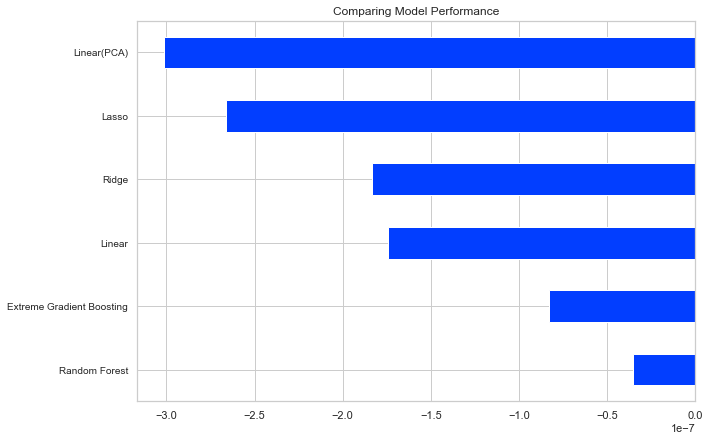

In [28]:
model_scores_df = pd.DataFrame.from_dict(model_scores, orient = 'index')
model_scores_df.columns = ["Neg. Mean Squared Error"]
plt.figure(figsize = (10, 7))
ax = model_scores_df["Neg. Mean Squared Error"].sort_values(ascending=False).plot(kind = "barh", title = "Comparing Model Performance")
fig = ax.get_figure()
axes = plt.gca()
plt.yticks(fontsize = 10)
#plt.show()
fig.savefig('model_comparison.jpg', bbox_inches='tight', dpi=300)

## (D) Archive

In [27]:
# manually creating model_scores dict
model_scores = {}
model_scores["Random Forest"] = -3.554107593003395e-08
model_scores["Extreme Gradient Boosting"] = -8.322085370215042e-08
model_scores["Lasso"] = -2.65918672898003e-07
model_scores["Ridge"] = -1.8350045158023289e-07
model_scores["Linear"] = -1.7429402374949595e-07
model_scores["Linear(PCA)"] = -3.013181658827342e-07
#model_scores["Neural Regression"] = -4.3356190018424304e-07  

### Linear model with RFE

In [ ]:
def linear_model(X_arr, y_arr, cols):
    
    ## determining optimum no of features
    
    nof_list=np.arange(1,len(cols))            
    neg_score=float(np.inf)
    nof=0           
    
    for n in range(len(nof_list)):
        model = LinearRegression()
        rfe = RFE(model,nof_list[n])
        X_rfe = rfe.fit_transform(X_arr,y_arr)
        cv_score_list = cross_val_score(model, X_rfe, 
                                        y_arr, cv=5, scoring='neg_mean_squared_error')
        
        if(cv_score_list.mean() < neg_score):
            neg_score = cv_score_list.mean()
            nof = nof_list[n]
            
    ## getting list of optimum features
    
    model = LinearRegression()

    # initializing RFE model
    rfe = RFE(model, nof)    

    # transforming data using RFE
    X_rfe = rfe.fit_transform(X_arr,y_arr)

    # fitting the data to model
    model.fit(X_rfe, y_arr)
    
    # saving model to file
    pkl_filename = "linear_model.pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(model, file)

    temp = pd.Series(rfe.support_, index = cols)
    selected_features_rfe = temp[temp==True].index

    print("Optimum number of features: %d" %nof)
    print("Selected features:", selected_features_rfe)
    print("Score with %d features: %f" % (nof, neg_score))
    
    return neg_score


# building the model
final_score = linear_model(X_arr, y_arr, cols)

# saving tuned model score to master dict
model_scores["Linear RFE"] = final_score

### Feature selection via Filter method

In [ ]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df_merged.corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
plt.show()

#Correlation with output variable
cor_target = abs(cor["value"])
#Selecting highly correlated features
relevant_features = cor_target[(cor_target>0.2) & (cor_target != 1.0)]  # anything above 0.2 gives nothing
relevant_features

# removing features with high levels of multicollinearity
selected_features_corr = df_merged[list(relevant_features.index)].corr()

# identifying all the features that have a correlation higher than 0.90 or lower than -0.90 indicating a strong positive or negative correlation

threshold_1 = 0.90
threshold_2 = -0.90

def features_high_corr(df_features_corr):
    columns = np.full((df_features_corr.shape[0],), True, dtype=bool)
    for i in range(df_features_corr.shape[0]):
        for j in range(i+1, df_features_corr.shape[0]):
            if (df_features_corr.iloc[i,j] >= threshold_1) | (df_features_corr.iloc[i,j] <= threshold_2) :
                if columns[j]:
                    columns[j] = False
    selected_columns = df_features_corr.columns[columns]
    return selected_columns

# list of features that are not highly correlated
selected_features = features_high_corr(selected_features_corr)
print("Features in dataset that are not highly correlated: ")
print(selected_features)